In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import datetime
import time
from collections import Counter
import csv
import duckdb
import folium

In [2]:
#Para cada usuario (id), vai existir um grafo onde os vértices são os estabelecimentos de check-in (location_id)
#Contando o histórico de estabelecimentos que cada usuário realizou check-in
    
#df = pd.read_csv('C:/Users/caca_/Desktop/Gowalla_totalCheckins.csv', sep="	")
df = pd.read_csv("arquivo_final.csv", sep=",")
df.columns = ['id_user', 'time', 'latitude', 'longitude' ,'location_id']

df['time'] = pd.to_datetime(df['time'])

df.head()

,id_user,time,latitude,longitude,location_id
0,17,2010-10-16 00:07:34+00:00,35.046108,-89.827722,864095
1,17,2010-10-14 14:38:26+00:00,35.072080,-89.948233,26904
2,17,2010-09-26 18:05:52+00:00,35.149988,-89.994296,35812
3,17,2010-09-25 21:37:20+00:00,35.176795,-89.916894,1214560
4,17,2010-09-25 18:54:52+00:00,35.154289,-89.993104,4425307


In [3]:
#Número de check-in por usuários

def total_check_users(df):
    number_location = []
    prim = df['id_user'][0]
    
    cont = 1
    
    for i in range(len(df)):
        if i+1 == len(df):
            number_location.append(cont)
        elif df['id_user'][i] == prim:
            cont+=1 
        else:
            number_location.append(cont)
            cont = 1
            prim = df['id_user'][i]

    return number_location

#print(number_location)
tam_checks = len(total_check_users(df))
print(tam_checks)

2534


In [4]:
#Filtrando a quantidade de usuarios que esteve no estado durante as chuvas
'''
Observação: Alterando as datas na variavel "query", é possível acompanhar a alteração na quantidade de pessoas no estado
do Tennessee e acompanhar quantas pessoas saíram
'''

# Convertendo a coluna 'time' para datetime no pandas
df['time'] = pd.to_datetime(df['time'])

#Usando duckdb para realizar uma consulta SQL 
con = duckdb.connect()
con.register('df', df)

query = """
SELECT * 
FROM df 
WHERE 
STRFTIME('%Y-%m-%dT%H:%M:%S', CAST(time AS TIMESTAMP)) LIKE '2010-05-01T%' 
OR 
STRFTIME('%Y-%m-%dT%H:%M:%S', CAST(time AS TIMESTAMP)) LIKE '2010-05-02T%'
"""

res = con.execute(query).fetchall()

# Obter e contar os usuários únicos
quant_users = set(row[0] for row in res)

print("Existiam %d pessoas no Tennessee na data das chuvas" % (len(quant_users)))


Existiam 107 pessoas no Tennessee na data das chuvas


In [5]:
#Criando o novo dataframe
lista = []

for valor in res:
    aux = []
    aux.append(valor[0])
    aux.append(valor[1])
    aux.append(valor[2])
    aux.append(valor[3])
    aux.append(valor[4])
    lista.append(aux)

df_new = pd.DataFrame(lista)
df_new .columns = ['id_user', 'time', 'latitude', 'longitude' ,'location_id']
df_new.head()

print(len(df_new))

258


In [6]:
#Número de check-in por usuários

aux = []
freq_users = []

#Pegando cada um dos id_users
for i in range(len(df_new)):
    aux.append((df_new['id_user'][i]))

#Counter = par chave, valor dos id_user e a quantidade de vezes que aparecem
for i in Counter(aux).values():
    freq_users.append(i)

print(freq_users)

[1, 10, 7, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 6, 4, 5, 3, 2, 1, 1, 8, 4, 1, 2, 3, 3, 2, 1, 1, 1, 5, 7, 5, 3, 1, 1, 5, 3, 3, 2, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 2, 1, 3, 1, 4, 1, 3, 6, 1, 1, 1, 2, 2, 1, 3, 1, 2, 1, 3, 1, 1, 1, 9, 3, 1, 4, 3, 2, 1, 1, 6, 3, 3, 4, 3, 1, 1, 4, 4, 2, 1, 3, 1, 2, 3, 1, 4, 2, 1]


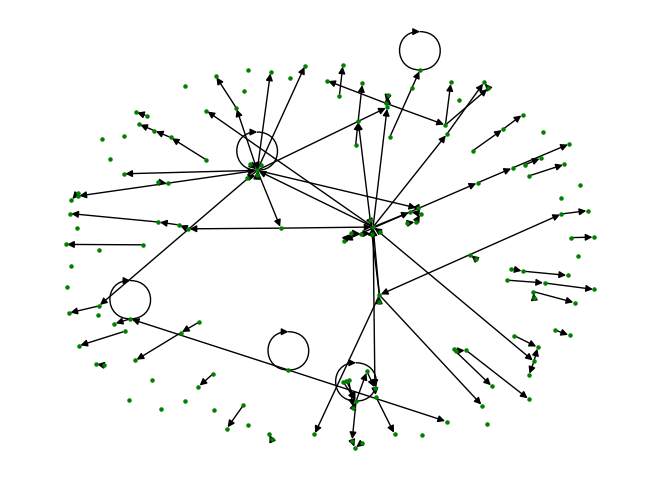

In [7]:
#Plote do grafo

df_new = df_new.sort_values(by="id_user")

G = nx.DiGraph()

for i in range(len(df_new)):
    if (i+1) < len(df_new) and df_new["id_user"][i] == df_new["id_user"][i+1]:
        origem = df['location_id'][i]
        destino = df['location_id'][i+1]
        G.add_edge(origem, destino)
    else:
        G.add_node(df['location_id'][i])

nx.draw(G, node_color='green', node_size=5)

In [8]:
#Plotar o novo mapa

#ideia: se o usuário tiver mais de um check-in, plotar uma linha entre os marcadores
#exemplo: id_user = 445

lat = df_new['latitude'][0]
long = df_new['longitude'][0]

mapa = folium.Map(location = [lat, long])
coordinates = []
coordinates_aux = []
z = 0

for num_users in freq_users:
    for i in range(z, z+num_users):
        z+=1
        coord_aux = []
        coord_aux.append(df_new['latitude'][i])
        coord_aux.append(df_new['longitude'][i])
        coordinates_aux.append(coord_aux)
    coordinates.append(coordinates_aux)
    coordinates_aux = []

for geom in coordinates:
    if len(geom) == 1:
        iframe = folium.IFrame(str(i))
        iframe = folium.IFrame(str(df_new['time'][i]))
        popup = folium.Popup(iframe, min_width=200, max_width=200)
        folium.Marker(location=[geom[0][0], geom[0][1]], popup=popup).add_to(mapa)
    else:
        for ponto in geom:
            iframe = folium.IFrame(str(i))
            iframe = folium.IFrame(str(df_new['time'][i]))
            popup = folium.Popup(iframe, min_width=200, max_width=200)
            folium.Marker(location=[ponto[0], ponto[1]], popup=popup).add_to(mapa)
        folium.PolyLine(locations=[geom], weight=5).add_to(mapa)
        
mapa

In [9]:
#2)a)
'''
Entre os dias 01 e 02 de maio de 2010, fortes chuvas causaram graves inundações no estado norte-americano do Tennessee.
Para se ter uma ideia da tragédia, mais de 20 pessoas morreram e centenas precisaram de ser resgatadas. Sendo assim,
a rede complexa aqui modelada busca representar o histórico de check-in realizados na rede social Gowala durante os 
dois dias do desastre. 
'''

'\nEntre os dias 01 e 02 de maio de 2010, fortes chuvas causaram graves inundações no estado norte-americano do Tennessee.\nPara se ter uma ideia da tragédia, mais de 20 pessoas morreram e centenas precisaram de ser resgatadas. Sendo assim,\na rede complexa aqui modelada busca representar o histórico de check-in realizados na rede social Gowala durante os \ndois dias do desastre. \n'

dict_items([(0, 62), (5, 2), (2, 11), (1, 78), (4, 1)])


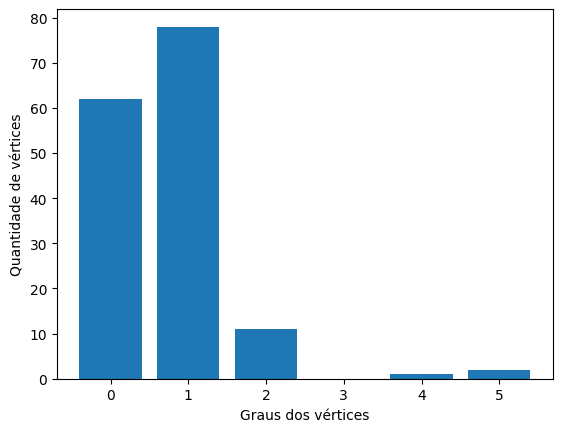

In [10]:
#2)b)
'''
Como cada vértice representa um estabelecimento onde é feito um check-in, o número de graus de entrada do vértice, nesse caso, indicaria
a quantidade de vezes que aquele determinado estabelecimento foi visitado por um usuário da rede social.
'''
graus = []

for node, grau in G.in_degree():
    graus.append(grau)

num_graus = Counter(graus)
x = num_graus.keys()
y = num_graus.values()

print(num_graus.items())

plt.bar(x,y)
plt.xlabel('Graus dos vértices')
plt.ylabel('Quantidade de vértices')
plt.show()
    

In [11]:
#2)c)
'''
Em relação aos grafos direcionados, existem dois tipos de componentes: fortemente e fracamente conectados. Componentes fortemente 
conectados são um subconjunto de nós que são alcançados com base na direção da aresta, enquanto que os componentes fracamente
conectados são aqueles que independem da direção da aresta. 
Nesse caso, existe uma interpretação possível para cada um deles:
'''

# Determinar os componentes fortemente conectados
fortemente_conectado = list(nx.strongly_connected_components(G))
num_fortemente_conectado = len(fortemente_conectado)
print("Número de Componentes Fortemente Conectados:", num_fortemente_conectado)

# Determinar os componentes fracamente conectados
fracamente_conectado = list(nx.weakly_connected_components(G))
num_fracamente_conectado = len(fracamente_conectado)
print("Número de Componentes Fracamente Conectados:", num_fracamente_conectado)

Número de Componentes Fortemente Conectados: 145
Número de Componentes Fracamente Conectados: 50


Coeficiente de clusterização médio: 0.002361


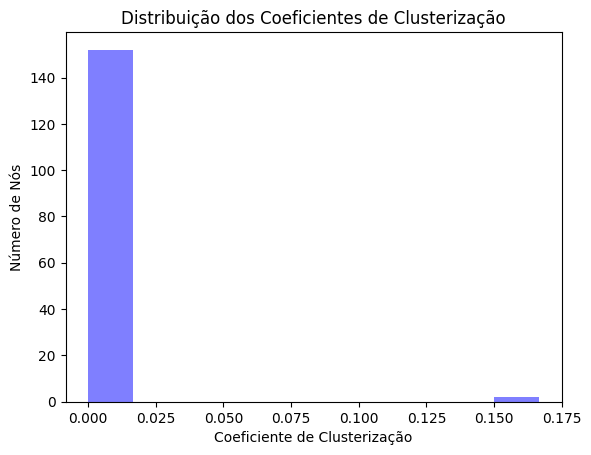

In [80]:
#2)d)
# Calcular o coeficiente de clusterização de cada nó
coeficiente_clusterizacao_medio = nx.average_clustering(G)

print("Coeficiente de clusterização médio: %f" %(coeficiente_clusterizacao_medio))

cluster_coeficientes = nx.clustering(G)

# Plotar a distribuição dos coeficientes de clusterização
plt.hist(list(cluster_coeficientes.values()), bins=10, alpha=0.5, color='b')
plt.xlabel('Coeficiente de Clusterização')
plt.ylabel('Número de Nós')
plt.title('Distribuição dos Coeficientes de Clusterização')

plt.show()

dict_items([(1, 26), (72, 1), (2, 15), (4, 2), (3, 6)])


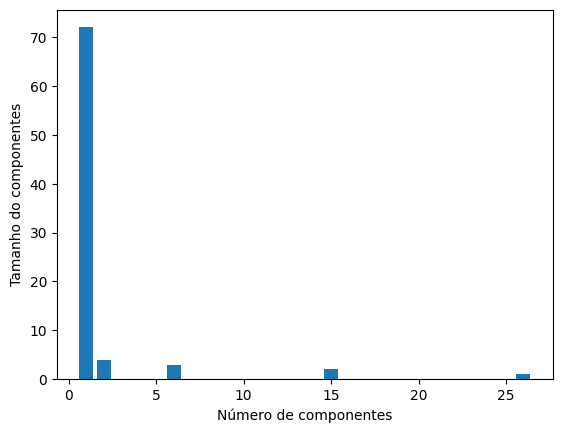

In [37]:
#2)e)
'''
Como há estabelecimentos que foram visitados por usuários distintos, se considerarmos o grafo formado
como sendo não-direcionado, temos que ambos os usuários formariam um mesmo componente. Dessa forma,
é possível que exista um único componente que concentre uma quantidade maior de vértices nele.
'''
#Transformando o grafo direcionado em não-direcionado para determinar o número de componentes
H = G.to_undirected()

num_componentes = []
for componente in nx.connected_components(H):
    num_componentes.append(len(componente))

total_componentes = Counter(num_componentes)

x = total_componentes.values()
y = total_componentes.keys()

print(total_componentes.items())

plt.bar(x,y)
plt.xlabel('Número de componentes')
plt.ylabel('Tamanho do componentes')
plt.show()

In [93]:
#2)f)
#Overlap 
# O(u,v) = (vizinho comuns de u e v) / (vizinhos de u + vizinho de v)
# O(u,v) = intercesão dos vizinhos de u e v / união dos vizinhos de u e v

#Gerando o overlap do maior componente do grafo analisado

#Verifica cada par de vértices u e v
for u in G.nodes():
    for v in G.nodes():
        #Se os vértices são distintos e não estão conectados
        if u != v and not G.has_edge(u, v):  
            vizinhos_1 = set(G.neighbors(u))
            vizinhos_2 = set(G.neighbors(v))
            
            vizinhos_comuns = vizinhos_1.intersection(vizinhos_2)
            vizinhos_todos = vizinhos_1.union(vizinhos_1)

            if len(vizinhos_todos) != 0:
                overlap = len(vizinhos_comuns) / len(vizinhos_todos) 
                print("Vertices: %d e %d" %(u, v))
                print(f"Overlap: ", overlap)
                print("\n")

Vertices: 26904 e 864095
Overlap:  0.0


Vertices: 26904 e 1214560
Overlap:  0.0


Vertices: 26904 e 4425307
Overlap:  0.0


Vertices: 26904 e 28439
Overlap:  0.0


Vertices: 26904 e 137805
Overlap:  0.0


Vertices: 26904 e 138992
Overlap:  0.0


Vertices: 26904 e 664053
Overlap:  0.0


Vertices: 26904 e 663944
Overlap:  0.0


Vertices: 26904 e 94178
Overlap:  0.0


Vertices: 26904 e 663957
Overlap:  0.14285714285714285


Vertices: 26904 e 119619
Overlap:  0.0


Vertices: 26904 e 663817
Overlap:  0.0


Vertices: 26904 e 119534
Overlap:  0.0


Vertices: 26904 e 2190455
Overlap:  0.0


Vertices: 26904 e 132612
Overlap:  0.0


Vertices: 26904 e 35031
Overlap:  0.0


Vertices: 26904 e 253826
Overlap:  0.0


Vertices: 26904 e 222509
Overlap:  0.0


Vertices: 26904 e 155626
Overlap:  0.0


Vertices: 26904 e 45915
Overlap:  0.0


Vertices: 26904 e 452100
Overlap:  0.0


Vertices: 26904 e 30595
Overlap:  0.0


Vertices: 26904 e 1373244
Overlap:  0.0


Vertices: 26904 e 1132614
Overlap:  0.0




Distância média: 4.464789


dict_items([(0, 72), (1, 76), (2, 127), (3, 182), (4, 169), (5, 154), (6, 120), (7, 77), (8, 54), (9, 45), (10, 29), (11, 15), (12, 10), (13, 5), (14, 1)])


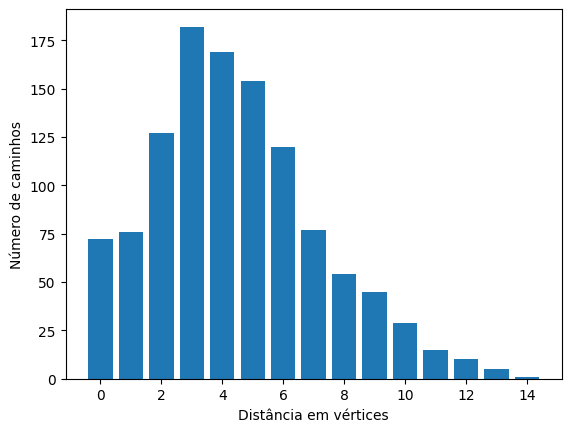

In [84]:
#2)g)
'''
'''

#Gerando todos os componentes do grafo
componentes = nx.connected_components(H)
for i in componentes:
    #Considerando somente o maior componente
    if len(i) == 72:
        #Considerando o subgrafo do grafo direcionado
        subgrafo_G = G.subgraph(i)

#nx.draw(subgrafo_G, node_color='green', node_size=5)

distancias = dict(nx.all_pairs_shortest_path_length(subgrafo_G))
distribuicao_distancia = []

#Gerando todas as distâncias
for u, v_dist in distancias.items():
    for v, dist in v_dist.items():
        #print("Distância de %u para %d: %d" % (u, v, dist))
        distribuicao_distancia.append(dist)

dist_valores = Counter(distribuicao_distancia)

x = dist_valores.keys()
y = dist_valores.values()

valores = 0
total = 0

#Calculando a distância média manualmente
for k,v in dist_valores.items():
    valores += k*v
    total += v

media = valores/total

print("Distância média: %f" % (media))
print("\n")

print(dist_valores.items())

plt.bar(x,y)
plt.xlabel('Distância em vértices')
plt.ylabel('Número de caminhos')
plt.show()


In [ ]:
#2)h)